In [2]:
from copy import deepcopy

# Data handling and plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Landlab and terrainbento
from landlab import RasterModelGrid, imshow_grid
from landlab.components import (NormalFault,
                                ChannelProfiler,
                                DepressionFinderAndRouter,
                                SinkFillerBarnes,
                                FlowDirectorD8,
                                FlowAccumulator,
                                ChiFinder
                                )
from landlab.values import constant, plane, sine, random
from landlab.utils import get_watershed_masks
from terrainbento import Basic, BasicRt, Clock
from terrainbento.boundary_handlers import GenericFuncBaselevelHandler

# Own local functions
from output_writers import output_writer_1, print_model_local_time
from landlab_utils import (extract_top_outlet_node_ids,
                           extract_row_outlet_node_ids,
                           extract_row_transsect)

In [3]:
np.random.seed(32)
acc_time = [0, 2790000, 2800000, 2910000, 2920000, 2940000]
acc_rate = [0, 0, 0.00013333333333333334, 0.00013333333333333334, 0, 0]
acc_rate = [0, 0, 0.00013333333333333334, 0.00013333333333333334, 0, 0]
step = 10000

def increase_upper_layer(grid, t):
    dzdt = rmg.x_of_node * 0
    # Interpolate accumulation rate
    rate = np.interp(t, acc_time, acc_rate)
    if rate != 0:
        # Calculate topography - contact elevation difference
        contact = grid.at_node['lithology_contact__elevation']
        topo = grid.at_node['topographic__elevation']
        upper_thickness = (topo - contact)
        grid.at_node['upper_layer_thickness'] = upper_thickness
        # Find exposed lower layer
        exposed_lower = upper_thickness <= 0
        extra_elev = 1e-4
        # Set contact elevation to the level of exposed lower layer
        contact[exposed_lower] = topo[exposed_lower] + extra_elev
    # Calculate total accumulation and deposit upper layer material
    accumulation = rate * step
    grid.at_node['topographic__elevation'] += accumulation
    return dzdt

fields = [
         'cumulative_elevation_change',
         'drainage_area',
         'initial_topographic__elevation',
         'topographic__elevation',
         'topographic__steepest_slope',
         'lithology_contact__elevation',
         'upper_layer_thickness',
         'substrate__erodibility'
         ]

In [4]:
# Set up the initial surface and boundary conditions (400, 400)
rmg = RasterModelGrid(shape=(400, 400),
                      xy_spacing=10,
                      xy_axis_units="m")
rmg.add_zeros('upper_layer_thickness',at='node',units='m')

data = pd.read_csv('times_rates_rapid_fix.txt', sep='\t')

z = random(rmg, 'topographic__elevation', distribution='normal')
z *= 2
rmg['node']['topographic__elevation'] += 267.5
p = 1 - rmg.y_of_node / rmg.y_of_node.max()
p *= 2
rmg['node']['topographic__elevation'] += p
contact = deepcopy(rmg['node']['topographic__elevation'])
# rmg.add_field('lithology_contact__elevation', contact)
rmg.add_zeros('lithology_contact__elevation', at='node')
rmg.at_node['lithology_contact__elevation'] += 270

In [5]:
row_y_coords = np.unique(rmg.node_y)

fault_trace = {'x1': rmg.node_x[0],
               'x2': rmg.node_x[-1],
               'y1': row_y_coords[-2],
               'y2': row_y_coords[-2]}

# NormalFault simulating base level drop for the topmost nodes.
nf = NormalFault(grid=rmg,
                 faulted_surface='topographic__elevation',
                 fault_throw_rate_through_time={'rate': data['rate'],
                                                'time': data['timestep']},
                 fault_trace=fault_trace,
                 include_boundaries=True)

# GenericFuncBaselevelHandler for upper_layer material accumulation.
gfbh = GenericFuncBaselevelHandler(rmg, function=increase_upper_layer,
                                   modify_core_nodes=True,
                                   )

# Close edge nodes, only leave top edge nodes open (core).
rmg.set_status_at_node_on_edges(right=rmg.BC_NODE_IS_CLOSED,
                                left=rmg.BC_NODE_IS_CLOSED,
                                top=rmg.BC_NODE_IS_CORE,
                                bottom=rmg.BC_NODE_IS_CLOSED,
                                )

output_prefix = './netcdf_output/t9-1_f_3990_Rt_acc3_rand42_2940000_k1_1e-5_k2_2e-5__d_1e-2_nsp_1_r10'

In [6]:
# Model setup
clockRt = Clock(0, step, 2940000)

modelRt = BasicRt(clockRt,
                  grid=rmg,
                  regolith_transport_parameter=0.01,
                  water_erodibility_lower=0.00001,
                  water_erodibility_upper=0.00002,
                  boundary_handlers={'NormalFault': nf,
                                     'GenericFuncBaselevelHandler': gfbh},
                  contact_zone__width=0.000001,
                  output_interval=20000,
                  output_prefix=output_prefix,
                  output_writers={'function': [print_model_local_time]},
                  fields=fields,
                  n_sp=1,
                  m_sp=0.5,
                  flow_director='FlowDirectorD8',
                  )

modelRt.run()

C:\anaconda\envs\landlab_2-4\lib\site-packages\terrainbento\base_class\two_lithology_erosion_model.py:134: RuntimeWarning: overflow encountered in exp
  / self.contact_width


Model time: 0.0 - Local time: Wed Jul  6 18:43:32 2022
Model time: 20000.0 - Local time: Wed Jul  6 18:43:35 2022
Model time: 40000.0 - Local time: Wed Jul  6 18:43:36 2022
Model time: 60000.0 - Local time: Wed Jul  6 18:43:37 2022
Model time: 80000.0 - Local time: Wed Jul  6 18:43:38 2022
Model time: 100000.0 - Local time: Wed Jul  6 18:43:39 2022
Model time: 120000.0 - Local time: Wed Jul  6 18:43:40 2022
Model time: 140000.0 - Local time: Wed Jul  6 18:43:40 2022
Model time: 160000.0 - Local time: Wed Jul  6 18:43:41 2022
Model time: 180000.0 - Local time: Wed Jul  6 18:43:42 2022
Model time: 200000.0 - Local time: Wed Jul  6 18:43:43 2022
Model time: 220000.0 - Local time: Wed Jul  6 18:43:44 2022
Model time: 240000.0 - Local time: Wed Jul  6 18:43:45 2022
Model time: 260000.0 - Local time: Wed Jul  6 18:43:46 2022
Model time: 280000.0 - Local time: Wed Jul  6 18:43:46 2022
Model time: 300000.0 - Local time: Wed Jul  6 18:43:47 2022
Model time: 320000.0 - Local time: Wed Jul  6 18:

In [7]:
# Save stack of all netcdfs for Paraview to use.
modelRt.save_to_xarray_dataset(filename=output_prefix+"_timed.nc",
                                time_unit="years",
                                reference_time="model start",
                                space_unit="meters")
modelRt.remove_output_netcdfs()

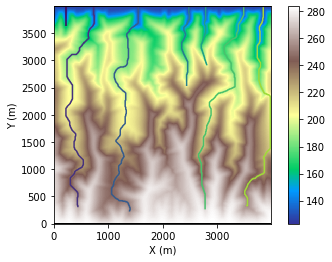

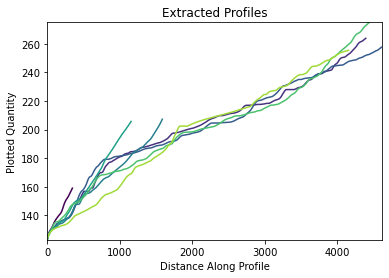

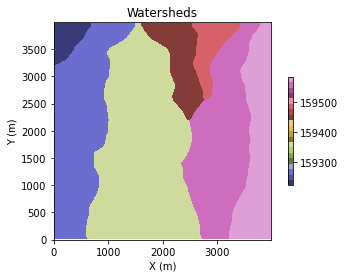

In [9]:
# Result analysis
mg = deepcopy(modelRt.grid)
mg.set_status_at_node_on_edges(right=mg.BC_NODE_IS_CLOSED,
                                left=mg.BC_NODE_IS_CLOSED,
                                top=mg.BC_NODE_IS_CLOSED,
                                bottom=mg.BC_NODE_IS_CLOSED,
                                )
limit=100000
outlets = extract_top_outlet_node_ids(mg, limit=limit)
row_y = 3980
outlets = extract_row_outlet_node_ids(mg, row_y)
mg.status_at_node[mg.y_of_node==row_y] = 4
mg.status_at_node[outlets] = 1

sf = SinkFillerBarnes(mg, fill_flat=False, ignore_overfill=False)
sf.run_one_step()
fd = FlowDirectorD8(mg)
fa = FlowAccumulator(mg, 'topographic__elevation',
                     flow_director='D8')
fa.run_one_step()
prf = ChannelProfiler(mg, number_of_watersheds=len(outlets),
                      main_channel_only=True,
                      outlet_nodes=outlets,
                      minimum_channel_threshold=50000,
                      minimum_outlet_threshold=limit
                      )
prf.run_one_step()
mask = get_watershed_masks(mg)
plt.figure(1)
prf.plot_profiles_in_map_view(cmap='terrain')
plt.figure(2)
prf.plot_profiles()
plt.figure(3)
imshow_grid(mg, mask,
            plot_name='Watersheds',
            cmap='tab20b',
            color_for_closed=None,
            shrink=0.5)